In [113]:
import os
import sys
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [87]:
# read excel file
file_path = 'tippekuponger.xlsx'

if not os.path.exists(file_path):
    print(f"File {file_path} does not exist.")
else:
    try:
        df = pd.read_excel(file_path)
        print("Excel file read successfully.")
        df.columns = [x.lower() for x in df.columns]  # Convert column names to lowercase
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")

# retrieve home and away teams from 'KAMP' column
df[['home_team', 'away_team']] = df['kamp'].str.extract(r'^(.*?)\s*-\s*(.*)$')
df.drop(columns=['kamp'], inplace=True)
df.head()

Excel file read successfully.


,trekningsdato,spill,tippekupong_id,konkurranse,tips,resultat,rett_tips,kupong_antall_rette,kupong_pris,home_team,away_team
0,2021-01-03,TIPPING SØNDAG,36084032471631696,ENG Premier League,HUB,B,1,7,6,Chelsea,Manchester City
1,2021-01-03,TIPPING SØNDAG,36084032471631696,ENG Premier League,U,B,0,7,6,Newcastle,Leicester
2,2021-01-03,TIPPING SØNDAG,36084032471631696,ITA Serie A,H,H,1,7,6,Juventus,Udinese
3,2021-01-03,TIPPING SØNDAG,36084032471631696,ITA Serie A,U,B,0,7,6,Benevento Calcio,Milan
4,2021-01-03,TIPPING SØNDAG,36084032471631696,ITA Serie A,H,H,1,7,6,Roma,Sampdoria


In [ ]:
df.shape

(9012, 12)

In [92]:
# tippekuponger
unique_coupons = df.groupby(['tippekupong_id'])
unique_coupons.size().sort_values(ascending=False)

tippekupong_id
36097822451977104    24
36099482424578600    24
36084032471631696    12
36097182129186096    12
36096942424975696    12
                     ..
36091802359842304    12
36091832170573600    12
36091862382200896    12
36091872388429104    12
36100762357779904    12
Length: 749, dtype: int64

In [100]:
# hjemme, borte eller uavgjort
tip_accuracy = (
    df.groupby("tips")["rett_tips"].agg(total = "count", correct = "sum")
)
tip_accuracy['accuracy'] = tip_accuracy['correct'] / tip_accuracy['total']
tip_accuracy.sort_values(by='accuracy', ascending=False, inplace=True)
print(tip_accuracy)

tip_accuracy = tip_accuracy.reset_index(inplace=True, drop=True)

      total  correct  accuracy
tips                          
HUB     720      720  1.000000
HB      322      254  0.788820
HU     1343      948  0.705882
UB     1306      856  0.655436
H      2997     1792  0.597931
B      1359      695  0.511405
U       965      250  0.259067


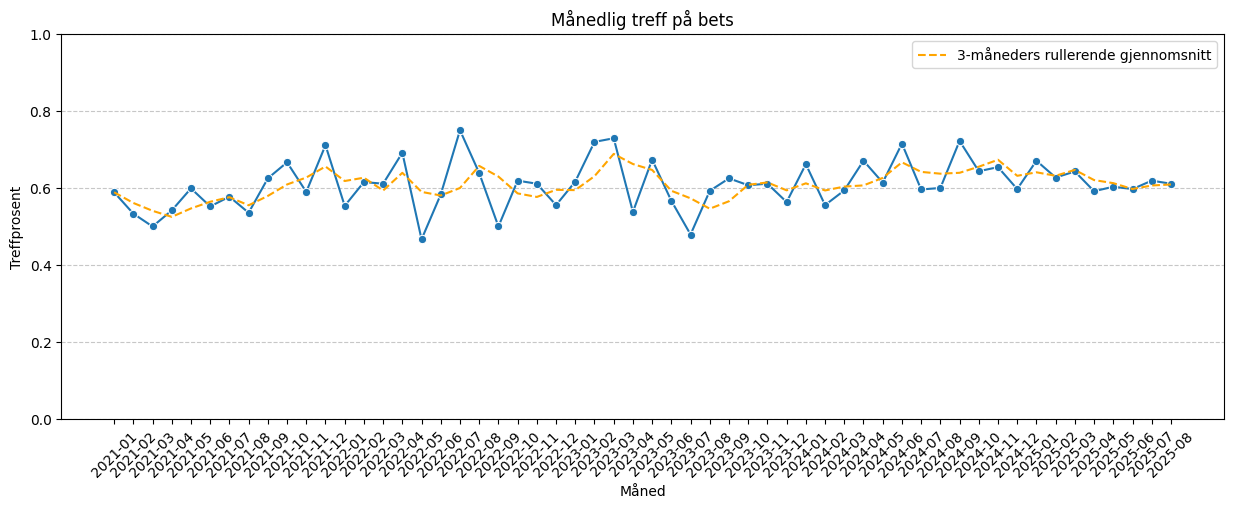

In [ ]:
# treff på bets over tid

df['year_month'] = df['trekningsdato'].dt.to_period('M').astype(str)
monthly_accuracy = (
    df.groupby('year_month')['rett_tips'].agg(total='count', correct='sum')
)

monthly_accuracy['accuracy'] = monthly_accuracy['correct'] / monthly_accuracy['total']
monthly_accuracy.reset_index(inplace=True)

plt.figure(figsize=(15, 5))

# plot monthly accuracy
sns.lineplot(data=monthly_accuracy, x='year_month', y='accuracy', marker='o')

# plot overall mean accuracy
overall_accuracy = monthly_accuracy['accuracy'].mean()
#plt.axhline(overall_accuracy, color='red', linestyle='--', label='Gjennomsnittlig treffprosent')
#plt.legend()

rolling_mean = monthly_accuracy['accuracy'].rolling(window=3, min_periods=1).mean()
plt.plot(monthly_accuracy['year_month'].astype(str), rolling_mean, color='orange', linestyle='--', label='3-måneders rullerende gjennomsnitt')
plt.legend()

plt.title('Månedlig treff på bets')
plt.xlabel('Måned')
plt.ylabel('Treffprosent')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

Slope: 0.0010, p-value: 0.0542


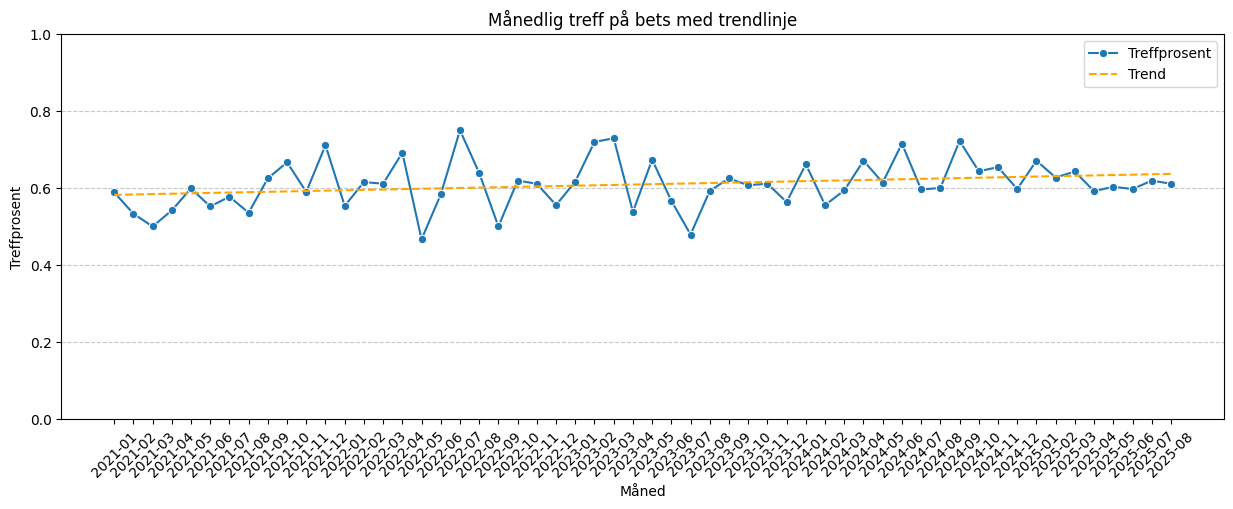

In [114]:
# lineær regresjon
monthly_accuracy["month_num"] = np.arange(len(monthly_accuracy))
slope, intercept, r_value, p_value, std_err = linregress(monthly_accuracy['month_num'], monthly_accuracy['accuracy'])
print(f"Slope: {slope:.4f}, p-value: {p_value:.4f}")

monthly_accuracy['trend'] = intercept + slope * monthly_accuracy['month_num']

plt.figure(figsize=(15, 5))
sns.lineplot(data=monthly_accuracy, x='year_month', y='accuracy', marker='o', label='Treffprosent')
sns.lineplot(data=monthly_accuracy, x='year_month', y='trend', color='orange', linestyle='--', label='Trend')
plt.title('Månedlig treff på bets med trendlinje')
plt.xlabel('Måned')
plt.ylabel('Treffprosent')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.show()
